# Corpus Exploration Stage

## Overview

This notebook sets out some of the methods used for examining the corpus generated at any stage in the process of corpus construction. 

There are two special cases:
1. The first iteration: all preprocessed data is passed in. This may be a lot of data compared to other steps in the process.
2. The final iteration. Here the same methods of corpus exploration are used in order to derive some insight from the corpus rather than feeding in to the labelling phase.

Both will cases will be given special consideration when relevant.

The notebook covers:

1. Initial candidate_corpus generation and loading of a pre-generated candidate corpus
2. Exploration of the corpus by:
 1. inspecting raw text,
 2. concordancing,
 3. collocation analysis,
 4. cooccurrence networks, and
 5. topic modelling.
3. How to use the results of this exploration to move on to the labelling stage or to conclude the corpus construction process.

We first load our libraries.

In [1]:
import glob
import html
from multiprocessing import Pool
import os
import pickle
import random
import re
import logging # Logging is useful to see the process of the topic models.
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s',
    level=logging.INFO
)

from gensim import corpora
from gensim.models import LdaMulticore, TfidfModel
from gensim.matutils import corpus2csc

from IPython.display import HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from jupyter_dash import JupyterDash
import dash_cytoscape as cyto
from dash import dcc
from dash import html as dash_html
from dash.dependencies import Input, Output, State

from nltk.collocations import BigramCollocationFinder
from nltk.corpus import stopwords, words
from nltk.metrics import BigramAssocMeasures
from nltk.text import Text
from nltk.tokenize import RegexpTokenizer

import numpy as np

import pandas as pd

# If importing NL_helpers (below) throws up a warning from NLTK, 
# you may need to run the following:
# import nltk
# nltk.download('stopwords')

# Set random seed for reproducability
random.seed(10)

At various points, this notebook saves results. Since the same code is used during multiple iterations of the same process, it is sensible to register which iteration you are on here. This variable will be used in the filenames assigned to the output of the worksheet.

In [2]:
ITERATION = 1

## Data Load

We load in the corpus we are exploring. This will either be from a previous iteration of the corpus construction process, or will be the original dataset (or some subset of it). In this case, we start with a subset of the processed dataset containing matches for the regex expression 'philoso*'. This is more managable than loading the entire dataset and should help us to pick out at least some useful texts. In addition, any system which cannot improve on merely searching for the word 'philosophy' is hardly worth writing home about!

### First Iteration: Starting with a Keyword Search

This section implements a keyword search of the preprocessed data. The result will be saved as `candidate_corpus_0`.

In [3]:
dataset_path = '../Dataset/processed-data/' # Preprocessed data directory.
filter_string = 'philoso*' # RE search string.
lower = True # Whether to make all article text lower case.
tarballs = glob.glob(dataset_path + '*.tar.gz') # Reads all dataset tarballs from
# data directory.

We define a search function to return all articles with a match. If the argument `lower` is `True` then the article text is converted to lower case.

In [4]:
def search_text(dataframe, re_string, lower=False):
    """
    Given pandas dataframe with 'Text' column as generated in preprocessing
    stage, search for regular expression string within 'Text' column content
    and return a list of the article codes containing the search string.
    """
    article_codes = set()
    for row in dataframe.itertuples():
        for string in row.Text:

            if lower:
                string = string.lower()

            match = re.search(re_string, string)

            if match:
                article_codes.add(row.Index)

    return list(article_codes)



def search_and_collect(
        tarball_path, 
        dataset_path = dataset_path, 
        filter_string = filter_string,
        lower = lower):
    """ 
    This function reads the pickled dataframe contained at tarball_path
    and calls the search_text, returning a filtered version of the dataframe
    containing only articles which match the result.
    """
    
    # Load dataframe.
    dataframe = pd.read_pickle(tarball_path)
    
    # Collect codes of matching articles.
    match_codes = search_text(dataframe, filter_string, lower=lower)
    
    filtered_dataframe = dataframe.loc[match_codes]
    
    return filtered_dataframe

In [10]:
if __name__ == '__main__': # This 'if' statement is a standard way 
    # of wrapping up loops for multiprocessing.
    with Pool(processes=8) as pool:
        match_dfs = pool.imap(search_and_collect, tarballs)
        match_dfs = list(match_dfs)

We concatentate the matches from each slice of the processed data. The result is saved as `candidate_corpus_0.tar.gz`. **Be careful running the following cell as it may override previous iterations.**

In [15]:
keyword_df = pd.concat(match_dfs)
keyword_df = keyword_df[~keyword_df.astype(str).duplicated()] # Delete duplicates if any exist.
keyword_df.to_pickle(f'../Corpora/candidate_corpus_{ITERATION-1}.tar.gz')
del keyword_df, match_dfs

### Loading Candidate Corpus From Previous Iteration

We load the candidate corpus we wish to explore. By default, this is the initial corpus as saved in the previous section.

In [6]:
candidate_corpus = pd.read_pickle(f'../Corpora/candidate_corpus_{ITERATION-1}.tar.gz')

In [7]:
candidate_corpus

,Title,Text
LWM_18761012_ARTICLE7,UNTITLED,[An Order in Council fixes the following as th...
WC_18880228_ARTICLE30,PROFESSOR BLACKIE ON CHRISTIANITY.,"[.On a Sunday night, Emeritus Professor Blac&i..."
LWM_18870520_ARTICLE29,SCRAPS.,[A new use for the tobacco plant is said to ha...
LWM_18761005_ARTICLE7,KINGST0N.,"[(FBOM AW OCCASIONAL CORRESPONDENT.), Sept. 28..."
WC_18920629_ARTICLE22,EDUCATIONAL INSTITUTE.,[Conference of the Wanganui ■^Httncb of the ab...
...,...,...
ESD_18970827_ARTICLE2,SPIRITUALISM AND THEOSOPHY.,"[In the Choral Hall last night Colonel Oleott,..."
ESD_18960125_ARTICLE54,CYCLING NOTES.,"[[By Rover.], Correspondence and queries are i..."
ST_18810304_ARTICLE18,THE SOUTHLAND JOCKEY CLUB AUTUMN MEETING.,"[_ _TT~: — •"" ' . j :  FIRST DAY."" [ Officers..."
ESD_18781213_ARTICLE40,OUR LADIES' LETTER.,"[Paris, October 26. ( Ditizens having placed t..."


Our candidate corpus of matches for 'philoso*' contains 49060 articles.

## Corpus Inspection

A few steps are worth taking which do not require any natural language processing. We look at some simple distributions across locations, titles, and times. We then manually inspect a random collection of articles.

### Distributions

When considering the distribution of articles in our candidate corpus, we will want to compare it to the distribution in the overall dataset. For this reason, we load the metadata produced in the previous step.

In [8]:
items_by_slice = pd.read_pickle('../Dataset/processed-data/meta/items_by_slice.tar.gz')

We will also want to take the article codes and extract the newspaper and year information which it contains.

In [9]:
def add_title_and_year(df):
    """Add 'Newspaper', 'Year', and 'Date' column to dataframe with
    'Text' column."""
    df['Newspaper'] = df.index.map(lambda x: x[0:x.find('_')])
    df['Date'] = df.index.map(lambda x: x[x.find('_')+1:x.find('_')+9])
    df['Year'] = df.index.map(lambda x: x[x.find('_')+1:x.find('_')+5])
    df['Year'] = pd.to_numeric(df['Year'])

We add this information to both the candidate corpus and the items by slice.

In [10]:
add_title_and_year(candidate_corpus)
add_title_and_year(items_by_slice)

We can look at the distribution of articles across time.

<AxesSubplot:ylabel='Frequency'>

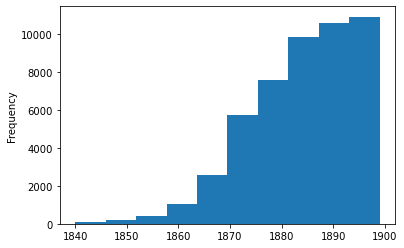

In [11]:
candidate_corpus['Year'].plot(kind='hist')

Compared to the original dataset:

<AxesSubplot:ylabel='Frequency'>

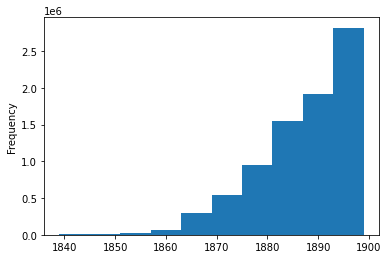

In [12]:
items_by_slice['Year'].plot(kind='hist')

Here we can pick out differences in coverage by year. It looks like a corpus created by simple regular expression keyword search has gaps between years which are smaller (relatively) than those in the complete dataset.

And by region:

In [16]:
with open('../Dataset/processed-data/meta/code2region.pickle', 'rb') as fin:
    code2region = pickle.load(fin)

In [17]:
candidate_corpus['Region'] = candidate_corpus['Newspaper'].map(lambda x: code2region[x])
items_by_slice['Region'] = items_by_slice['Newspaper'].map(lambda x: code2region[x])

<AxesSubplot:>

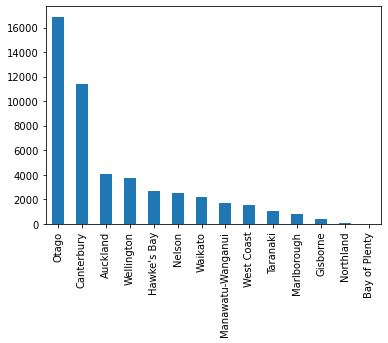

In [18]:
candidate_corpus['Region'].value_counts().plot(kind='bar')

<AxesSubplot:>

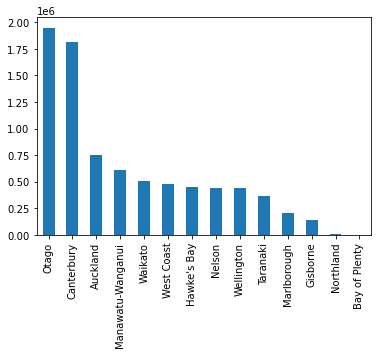

In [19]:
items_by_slice['Region'].value_counts().plot(kind='bar')

The dominance of Otago is increased when searching for 'philoso*' and similar. We also see Wellingtom and Hawke's bay jumping up in prominence. Otago was the first place in New Zealand with an academic chair in philosophy. Perhaps it is unsurprising that the word and its near (lexographically) neighbours are more prominent in Otago newspapers than in those in other regions.

These distribution charts can be useful for either noticing features of the candidate corpus which may be either interesting results in their own right or indications that something is going wrong in the selection process. Perhaps, for instance, the classifier in the previous section has learnt how to recording articles from a particular newspaper rather than the actual subject matter than the researcher is interested in.

_TODO: improve these plots. In particular: by adding both data sources to the same plot rather than using these pandas shorthands._

### Manual Inspection

The following function is used to rendered articles in html.

In [20]:
def html_text(index, dataframe, boldface=None):
    """
    Given article code, return html formatted text
    containing both heading and body text. Optionally, boldface
    matches of the boldface regex expression.
    Assumes dataframe contains a 'Text' column containing lists of
    strings as entries as well as 'Title', 'Newspaper' columns
    containing strings and a 'Date' column containing integers.

    I only escape html characters in the title and text. Newspaper and
    data should not have any html in them. Leaving them unescaped
    increases the chance of finding any such errors.
    """
    newspaper = dataframe.loc[index, 'Newspaper']
    date = dataframe.loc[index, 'Date']
    title = html.escape(dataframe.loc[index, 'Title'])
    text_blocks = dataframe.loc[index, 'Text']
    text = ''
    for block in text_blocks:
        tagged_string = f'<p>{html.escape(block)}</p>'
        text += tagged_string

    if boldface:
        match = re.search(boldface, text)
        if match:
            text = re.sub(boldface, f'<b>{match.group(0)}</b>', text)

    article_string = f'<h3>{title}</h3><h4>{newspaper} - {date}</h4>{text}'

    return HTML(article_string)

We now use ipython to allow us to select different articles for view.

At this point, it is important to keep a record of any articles which you definitely would want in your eventual corpus and those which you do not want. Note down the codes of any such articles as they will be useful in the labelling stage notebook.

We select a random sample of articles to view here. If there are known article codes which you would like to check for, they can be added to the list here.

In [21]:
sample_indices = random.sample(list(candidate_corpus.index), 100)

In [22]:
interact(
    html_text, 
    index=sorted(sample_indices), 
    dataframe=fixed(candidate_corpus), 
    boldface=fixed('philoso*\\w*')
)

interactive(children=(Dropdown(description='index', options=('AS_18831027_ARTICLE37', 'AS_18831127_ARTICLE38',…

<function __main__.html_text(index, dataframe, boldface=None)>

Looking through a sample here is likely to reveal some pretty abysmal OCR. We also see that the matches for 'philoso*' contain all sorts of material. We are unlikely to be interested in descriptions of people as philosophical, meaning calm or resigned (e.g. TS_18940414_ARTICLE10), or reference to 'philosophical instruments' meaning laboratory devices (e.g. WT_18721217_ARTICLE8). A letter in the Fielding Star encouraging readers to attend public lectures on phrenology as a 'system of mental philosophy' is also indicitive of the wide and messy range of things which might count as material on philosophy in this dataset (FS_18881002_ARTICLE13). On the edge, we might find an argument for stronger penalties for adulterating alcohol of the grounds that intellect (presumably) is our noblest faculty (THA_18870426_ARTICLE16). We would definitely want the, of its time, discussion of philosophy in the Arabic world presented in ME_18890125_ARTICLE33.

## Concordancing

It can be useful to generate concordances for keywords. This allows us to see these words in the context of our corpus.

This will be done using `NLTK`. We tokenise the text, but do not filter for stop words at this stage.

The tokenizer is `RegexpTokenizer` from `NLTK`. It uses a word definition of any combination of the letters a-z and the appostrophe. This will, for instance, remove any text with numbers in it (including, e.g., any words with OCR errors leading "o" to become "0").

In [9]:
tokenizer = RegexpTokenizer(r"[a-z']+")

candidate_corpus['Tokenised'] = candidate_corpus['Text'].apply(
    lambda x: tokenizer.tokenize(' '.join(x).lower())
)

We now use a very simple flat list representation of a subset of the corpus (1000 articles). This will be queried for words in context.

In [19]:
flat_list = []
for tokens in candidate_corpus['Tokenised'].sample(n=1000, random_state=1):
    for token in tokens:
        flat_list.append(token)
sample_text = Text(flat_list)
del flat_list

We can now query this `NLTK` `Text` object:

In [20]:
SEARCH_TERM = 'philosophy' # Change this variable to explore different terms in context.

sample_text.concordance(SEARCH_TERM, width=100, lines=150)

Displaying 150 of 398 matches:
 and keep on lookin' happy that's good clean philosophy for 'a man and if you do pass out before the
ing who consider themselves qcamged to teach philosophy through the medinm of pointed personalltias 
m auguste comte the foun der of the positive philosophy draws some very encouraging conclusions from
ed success without acquiring also a stock of philosophy and ability to usa it must be the necessity 
y means of everything that modem science and philosophy can teach to re move all the obstacles to co
ss in the night spent her time over books of philosophy although cotton spinning was started in japa
 this iz ati age of kulture an age ov fikool philosophy and while we have mme literary profuseuess i
 suppose be accused of morbid rancour or the philosophy of dissatisfaction only loving hearts who ha
t but royal hook under the garb of ' clothes philosophy ' he manifold ly sets forth the fact diogene
ollins lectured on the bible it morality aud philosophy and 

The use of philosophy here shows some material that looks sensible for a corpus investigating philosophical writing in these newspapers. We see discussions of key figures (Comte, Plato, Bacon). We also seem to see discussions of philosophy of religion, science, and politics. However, there are also indications of problems such as poor OCR, passing references to philosophy, use of 'philosophy' in pieces that look like the might be fictional (e.g. the first entry).

If the above code cell is rerun using the search term 'lecture', we see that there are lots of reports of lectures in the corpus.

The advantage of quick scanning of concordance results is that they provide clues to the kind of pieces which are slipping through the cracks of our classifiers. 

As the `Text` object takes up a lot of RAM, it is sensible to ensure that it is deleted from memory here.

In [21]:
del sample_text

## Collocations

Another way of determining the content of the candidate corpus is to consider what kind of words appear within a certain window of a search term. That is, to investigate *collocations* of search terms.

We measure the significant of collocations using _[pointwise mutual information](https://en.wikipedia.org/wiki/Pointwise_mutual_information)_. This is the probability of word 1 and word 2 appearing together divided by the product of the probabilities of word 1 and word 2.

Again, we use `NLTK`. Unlike in concordancing, we will remove a set of stopwords from our tokenised text. This reduces the computational load and means that we will focus on words which convey information about the content of the text rather than function words. We use the `NLTK` default English stopwords list.

In [11]:
stopword_set = set(stopwords.words('english'))

In [ ]:
# We start with a Text object representation of the whole corpus.
flat_list = []
for tokens in candidate_corpus['Tokenised']:
    for token in tokens:
        flat_list.append(token)
all_text = Text(flat_list)
del flat_list

In [ ]:
window_size = 5 # Change the size of the window of words before and after the search term.
search_term = 'philosophy' # Change to explore a different term.

# Collect all bigrams in window size.
bigrams = BigramCollocationFinder.from_words(all_text, window_size = window_size) 

At this point we define and apply two filtering functions. One removes all bigrams containing stopwords, the other removes all those which do not contain our search term. We also demand that all words we consider appear at least 10 times in our candidate corpus.

In [ ]:
term_filter = lambda *w: search_term not in w
stopword_filter = lambda w: w in stopword_set

In [ ]:
bigrams.apply_ngram_filter(term_filter)
bigrams.apply_word_filter(stopword_filter)
bigrams.apply_freq_filter(10)

In [ ]:
bm = BigramAssocMeasures() # Load association measures from NLTK
pmi_ws5 = bigrams.nbest(bm.pmi, 50) # Collect 50 best bigrams by pointwise mutual information.
pmi_ws5 # List the top 50 bigrams.

These results are mostly modifiers to the word 'philosophy'. Some interesting terms, such as 'zetetic', which likely refers to the 19th century flat earth movement, appear (e.g. [this](https://paperspast.natlib.govt.nz/newspapers/TO18891026.2.37.10?query=%22zetetic+philosophy%22&snippet=true) satirical piece). This provides another opportunity for strange results to be looked into. Any articles which are particularly desireable or non-desirable should be noted for possible use at the labelling stage.

In [ ]:
del all_text, bigrams

## Cooccurrence Networks

Where collocations reveal words which tend to appear near to one another, cooccurrence networks consider words which appear together in a given document.

We create networks of cooccurrence within candidate corpora. For this, and for the topic modelling approach which follows, we will switch from `NLTK` to `gensim` and from `ipython` widgets to `Dash`.

### Dictionary Creation

We need to create a dictionary of words whose cooccurences will be kept track of. There are a few different options here. One option which will be unfeasible in the case of a large corpus and pervasive OCR errors is to just collect all of the 'words' in the corpus. Even the introduction of a restriction that the words appear in some small number of documents will be insufficient for this.

One way to proceed is to restict ourselves to words in the `NLTK` `words.words()` list.

In [10]:
word_set = set(words.words())

According to the `NLTK` documentation this word list comes from Openoffice.org and other sources. The readme points to [this](https://en.wikipedia.org/wiki/Words_(Unix)) Wikipedia page. From this we conclude that we are dealing with a basic English spell checker word list. The following cell shows that it has around 236,000 words.

In [24]:
len(word_set)

235892

We begin by filtering out any 'words' which are one or two characters long as these are very unlikely to be content words. We also remove anything not in the word list.

In [12]:
candidate_corpus['Tokenised'] = candidate_corpus['Tokenised'].map(
    lambda x: [word for word in x if len(word)>2 and not word in stopword_set and word in word_set]
)

The topic modelling package `gensim` offers a dictionary creation method which takes a corpus and some parameters and returns a dictionary.

In [26]:
# Require a word to be in 50 documents to be included in dictionary.
# This can be changed dependent on amount of RAM available.
minimum_in_docs = 50 

# Require a word to be in less than 25% of the documents.
max_prop = 0.25

# Establish dictionary, remove extremes, store more compactly.
dictionary = corpora.Dictionary(candidate_corpus['Tokenised'])
dictionary.filter_extremes(no_below=minimum_in_docs, no_above=max_prop)
dictionary.compactify()

The dictionary in the first iteration of the project contains 17201 words.

In [27]:
print(dictionary)

Dictionary(17201 unique tokens: ['absence', 'atmospheric', 'baby', 'bale', 'bom']...)


It is usually a good idea to save your dictionary for later use.

In [ ]:
dictionary.save(f'../Dictionaries/candidate_corpus_{ITERATION-1}.dict')

***NB:*** There are alternative methods for generating dictionaries available. One of our main choice points was how to reduce ourselves to a more manageable number of words. We might want, for instance, to have just proper nouns or named entities. ***TODO: create appendix notebook with dictionary options.***

### Cooccurrence Tables

We now use this dictionary to generate a table of cooccurrences. This will be, in the case of the first iteration, a 17201 x 17201 matrix. Here we are getting in to serious RAM usage.

It may be useful to load a previously generated dictionary. If so, do it here:

In [13]:
dictionary = corpora.Dictionary.load(f'../Dictionaries/candidate_corpus_{ITERATION-1}.dict')

2021-11-17 14:27:30,960 : INFO : loading Dictionary object from ../Dictionaries/candidate_corpus_0.dict
2021-11-17 14:27:30,977 : INFO : Dictionary lifecycle event {'fname': '../Dictionaries/candidate_corpus_0.dict', 'datetime': '2021-11-17T14:27:30.977040', 'gensim': '4.1.2', 'python': '3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'loaded'}


It is convenient to define a corpus class for use with gensim. This allows us to iterate through items in the corpus. The class is initiated with the `candidate_corpus` dataframe and the dictionary we have just generated.

In [14]:
class Corpus():
    """
    Corpus class for use with gensim for topic modelling.

    Input: 1) pandas dataframe containing 'Tokenised' column with
    tokenised texts for each article.
        2) Dictionary for use with gensim.

    Main benefit is use of iterator method.
    """

    def __init__(self, corpus_df, dictionary):
        self.items = corpus_df
        self.dictionary = dictionary
        if 'BOW' not in self.items.columns:
            self.generate_bow()

    def __iter__(self):
        for bag in self.items['BOW']:
            yield bag

    def __len__(self):
        """Returns number of corpus items."""
        return len(self.items)

    def generate_bow(self):
        """
        Generates bag of words representation of tokenised text and adds
        it to item dataframe as column 'BOW'.
        """
        bags = {}
        for index, value in self.items['Tokenised'].iteritems():
            tokenised = value
            bags[index] = [self.dictionary.doc2bow(tokenised)]
        bags_df = pd.DataFrame.from_dict(
            bags,
            orient='index',
            dtype = object,
            columns=['BOW']
            )
        self.items = self.items.join(bags_df)

When we initiate the corpus class, it generates a 'BOW' column in our corpus dataframe. This contains word ids from the dictionary and frequency counts.

In [15]:
gensim_candidate_corpus = Corpus(candidate_corpus, dictionary)

In addition to a straight-forward bag-of-words representation of our documents by word frequency, we also look at the representation after [TF-IDF transformation](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).The TF-IDF transformation multiplies the frequency of a term in a document by the log of the ratio of the total number of documents to the number which contain the term. That is, it weights the appearance of words which are rare in the corpus more highly than those which are common across the corpus. The underlying thought here is that words which appear in a document but which are not common across the corpus tell us more about the content of the document than words which are common across the corpus.

We will here define a function which we can use for both the bag-of-words and TF-IDF representations of our documents.

In [30]:
def generate_dtm(corpus, tf_idf=False):
    """
    Given instance of Corpus class return the document
    term matrix and the term term matrix for the corpus.
    If tf_idf is True, then the matrices are returned
    for the tf-idf representation of the documents rather
    than the bag of words representation.
    """
    
    if tf_idf == True:
        representation = 'TF-IDF'
        tfidf_model = TfidfModel(corpus, dictionary=corpus.dictionary)
        corpus.items['TF-IDF'] = tfidf_model[corpus]
    else:
        representation = 'BOW'
    
    sparse = corpus2csc(corpus.items[representation])
    document_term_matrix = pd.DataFrame.sparse.from_spmatrix(sparse)
    del sparse
    document_term_matrix.index = corpus.dictionary.values()
    
    return document_term_matrix

In [31]:
bow_dtm = generate_dtm(gensim_candidate_corpus, tf_idf=False)

If this doesn't work, you will likely need to reduce the size of the dictionary. 

You may want to save these for matrices for future use (likely to take a long time).

In [ ]:
bow_dtm.to_pickle(f'../Pickles/bow_dtm_{ITERATION-1}.tar.gz')

We do the same for the tf-idf representation, deleting the bow representations in this case for the sake of memory.

In [32]:
del bow_dtm

In [ ]:
tfidf_dtm = generate_dtm(gensim_candidate_corpus, tf_idf=True)
tfidf_dtm.to_pickle(f'../Pickles/tfidf_dtm_{ITERATION-1}.tar.gz')

In this case we only save the dtm (as the tf-idf representation, being real-valued, produces larger files than the bow representation, which is integer valued).

I've found it easiest to delete all of these matrices and reload whichever variety are required in the next section.

In [ ]:
del tfidf_dtm

### Ranking Cooccurrences (Log Dice and MI)

At this point, we choose whether to use the bow or tf-idf representation. By default, I recommend using the tf-idf representation (as recommended by _insert citation from ws pc_).

In [33]:
tf_idf = True # For bag-of-words representation set this to false.

if tf_idf == True:
    document_term_matrix = pd.read_pickle(f'../Pickles/tfidf_dtm_{ITERATION-1}.tar.gz')
else:
    document_term_matrix = pd.read_pickle(f'../Pickles/bow_dtm_{ITERATION-1}.tar.gz')
    
term_term_matrix = document_term_matrix.dot(
        document_term_matrix.transpose()
    )

We now need a way to rank the importance of a given cooccurrence. Two options are given here. The first is the [log Dice score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient), the second is the [Mutual Information score](https://en.wikipedia.org/wiki/Mutual_information). We define functions for both.

Mutual information in a general information theoretical method for quantifying how much information about one random variable is given by another. In this case, we are interested in the information given by the frequency of one term about the frequency of another. That is, knowing that we have a certain "amount" of one term, what do we know about the "amount" of another.

The Dice coefficient is is closely related to the Mutual Information score. Unlike the mutual information score, 
(see [Rychlý 2008](https://www.sketchengine.eu/wp-content/uploads/2015/03/Lexicographer-Friendly_2008.pdf)). It is not affected by the size of the corpus and has a maximum of 14 - in which case the terms perfectly co-occur. 

In [34]:
def log_dice_coocs(term, dtm, ttm, num_coocs):
    """Return num_coocs with log dice significance stat given search term
    document-term matrix and term-term matrix. Return as
    pandas series with terms as indices and significances as values..
    ttm and dtm are pandas dataframes."""
    all_term_occurrences = dtm.sum(axis=1)
    term_occurrences = all_term_occurrences[term]
    cooccurrences = ttm.loc[term]
    log_dice = np.log2(2 * cooccurrences / (term_occurrences + all_term_occurrences)) + 14
    log_dice = log_dice.sort_values(ascending=False)[0:num_coocs]
    return log_dice


def mi_coocs(term, dtm, ttm, num_coocs):
    """Return num_coocs with mutual information sig score given search term
    document-term matrix and term-term matrix. Return as
    pandas series with terms as indices and significances as values..
    ttm and dtm are pandas dataframes."""
    num_documents = len(dtm.columns)
    all_term_occurrences = dtm.sum(axis=1)
    term_occurrences = all_term_occurrences[term]
    cooccurrences = ttm.loc[term]
    mi = np.log2(num_documents * cooccurrences / (term_occurrences * all_term_occurrences))
    mi = mi.sort_values(ascending=False)[0:num_coocs]
    return mi

We can have a look at the kind of coccurrences which these statistics produce now.

In [35]:
term = 'ethical'

top_25_mi = mi_coocs(term, document_term_matrix, term_term_matrix, 25)
top_25_mi

/home/joshua/anaconda3/envs/CorpusPaper/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


ethical         7.691427
renunciation    5.907378
rationally      5.854872
floss           5.691269
welter          5.446836
ethics          5.139396
usury           5.126139
ego             4.791394
masterful       4.729014
trine           4.700129
inculcation     4.446210
coincide        4.442932
disclaim        4.417556
pleasurable     4.378118
dialectic       4.342616
sensuality      4.321578
imitator        4.313263
sures           4.308091
stain           4.300440
testa           4.212838
aggravate       4.187255
vicarious       4.182664
niggardly       4.170918
readjustment    4.152602
turbulent       4.092258
dtype: float64

_TODO: sort out divide by zero issue_

With the term 'ethical' we get some interesting scores. Obviously, the appearance of 'ethical' tells you something about whether 'ethical' will appear in a text... More significantly, we see terms for pleasure and the absense of pleasue and terms concerning rational argument - such as 'rationally' and 'dialectic'. The appearance of 'floss' might lead us to investigate why such a strange term seems associated with 'ethical' in our corpus. The appearance of 'trine' suggests, perhaps, an ocr error for 'doctrine'.

The above is an example of the kind of initial reflection that such a list might generate.

We now look at the log Dice scores:

In [36]:
top_25_ld = log_dice_coocs(term, document_term_matrix, term_term_matrix, 25)
top_25_ld

ethical         11.076803
ethics           8.730650
renunciation     8.172492
ego              7.896980
rationally       7.849898
morality         7.724479
trine            7.555327
floss            7.534407
usury            7.509013
theosophy        7.407286
pleasurable      7.208365
sures            7.169761
stain            7.150015
moral            7.149221
organism         7.136908
doc              7.055616
coincide         7.041550
welter           7.036098
morals           6.909404
incarnation      6.899803
isolated         6.816451
doctrine         6.815781
basis            6.787103
testa            6.714468
religion         6.694466
dtype: float64

This is a similar list, but with perhaps more indication of religious doctrine.

### Cooccurrence Networks

We can generate _networks_ of cooccurrences and display them interactively. This is particularly useful for finding strong associations between terms. A network will contain cooccurrences for a given search term and then the cooccurrences of the cooccurrences.

We implement the cooccurrence networks using `Dash`. Pregenerated versions of this can be interacted with [here](https://nz-newspaper-philosophy.herokuapp.com/).

The first step is to define a function which produces a network in the appropriate format for a `Dash` cytoscape.

In [50]:
def network_dash(term, stat, dtm, ttm, num_coocs, sec_coocs):
    """Produce network dataframe formatted for Dash cytoscope."""
    
    # This big try/except structure is not ideal. It currently handles searches
    # for words which are not in the dictionary.
    
    try:
        if stat == 'ld':
            term_coocs = log_dice_coocs(term, dtm, ttm, num_coocs)
        elif stat == 'mi':
            term_coocs = mi_coocs(term, dtm, ttm, num_coocs)

        nodes = []
        node_names = set([term])
        edges = []

        for item in term_coocs.iteritems():
            node_names.add(item[0])
            if item[0] != term:
                edges.append({'data': {
                    'source': term,
                    'target': item[0],
                    'weight': item[1]}
                    }
                )

            if stat == 'ld':
                item_coocs = log_dice_coocs(item[0], dtm, ttm, sec_coocs)
            elif stat == 'mi':
                item_coocs = mi_coocs(item[0], dtm, ttm, sec_coocs)
            for sub_item in item_coocs.iteritems():
                node_names.add(sub_item[0])
                if item[0] != sub_item[0]:
                    edges.append({'data': {
                        'source': item[0],
                        'target': sub_item[0],
                        'weight': sub_item[1]}
                        }
                    )

        for name in node_names:
            nodes.append({'data': {
                'id': name,
                'label': name,
                'size': node_degree(name, edges)}
                }
            )

        network = nodes + edges

    except KeyError:
        
        network = [{'data': {'id': 'error', 'label': 'word not found', 'size': 10}}]
        
    return network



def node_degree(name, edges):
    """Helper for dash network. Returns degree of node given
    list of edges formatted for Dash cytoscape."""
    degree=0
    for edge in edges:
        if edge['data']['source'] == name or edge['data']['target'] == name:
            degree += 1
    return degree

We now run define a cytoscape and run it inline, within the notebook.

In [57]:
app = JupyterDash(__name__)

philo_cytoscape = cyto.Cytoscape(
        id='cooccurrence-network',
        minZoom=1,
        layout={'name': 'cose'},
        style={'width': '85%', 'height': '800px',
            'margin': 'auto', 'border-style': 'solid',
            'margin-top': '10px'},
        elements={},
        stylesheet=[
            {
                'selector': 'edge',
                'style': {
                    'width': 'mapData(weight, 3, 6, 1, 3)',
                    'line-color': 'silver'
                }
            },
            {
                'selector': 'node',
                'style': {
                    'content': 'data(label)',
                    'width': 'mapData(size, 1, 10, 10, 20)',
                    'height': 'mapData(size, 1, 10, 10, 20)'
                }
            },
            {
                'selector': 'label',
                'style': {
                    'font-size': 6,
                    'text-valign': 'center',
                    'text-background-color': 'white',
                    'text-background-opacity': 0.6,
                    'text-background-padding': 1,
                    'text-border-color': 'black',
                    'text-border-opacity': 1,
                    'text-border-width': 0.5
                }
            }
        ]
    )

app.layout = dash_html.Div([
    dash_html.H2("Cooccurrence Network"),
    dash_html.P("Search Term:"),
    dcc.Dropdown(
        id='search-term',
        #type='text',
        options = [{'label': word, 'value': word} for word in gensim_candidate_corpus.dictionary.values()],
        value = list(gensim_candidate_corpus.dictionary.values())[0]
    ),
    dash_html.P("Statistic:"),
    dcc.Dropdown(
        id='stat-choice',
        options=[
            {'label': 'Mutual information', 'value': 'mi'},
            {'label': 'Log Dice', 'value': 'ld'}
        ],
        value='mi'
    ),
    dash_html.P('Primary Cooccurences'),
    dcc.Slider(
        id='primary-coocs',
        min=1,
        max=50,
        step=1,
        value=15,
        marks = {n: f'{n}' for n in [i for i in range(1, 51) if i%5==0]}
    ),
    dash_html.P('Secondary Cooccurences'),
    dcc.Slider(
        id='secondary-coocs',
        min=1,
        max=15,
        step=1,
        value=5,
        marks = {n: f'{n}' for n in [i for i in range(1, 51) if i%5==0]}
    ),
    dash_html.Button('Submit', id='submit-val', n_clicks=0),
    philo_cytoscape
])

@app.callback(
    Output(component_id='cooccurrence-network', component_property='elements'),
    Input(component_id='submit-val', component_property='n_clicks'),
    State(component_id='stat-choice', component_property='value'),
    State(component_id='search-term', component_property='value'),
    State(component_id='primary-coocs', component_property='value'),
    State(component_id='secondary-coocs', component_property='value')
)
def update_network_stat(n_clicks, stat_value, search_value, primary_coocs, secondary_coocs):
    network = network_dash(
        term=search_value,
        stat=stat_value,
        dtm=document_term_matrix,
        ttm=term_term_matrix,
        num_coocs=primary_coocs,
        sec_coocs=secondary_coocs
    )
    return network 

if __name__ == '__main__':
    app.run_server(debug=True, mode='inline')

Click [here](https://tm4ss.github.io/docs/Tutorial_5_Co-occurrence.html) for more information of cooccurrence networks, including R code from which the above is adapted.

If moving on to topic modelling, delete the large matrices used for the cooccurrence networks.

In [59]:
del document_term_matrix, term_term_matrix

## Topic Modelling

The final method for investigating a candidate corpus is LDA topic modelling. LDA requires the number of topics we think there are to be set as a parameter. Many introductions are available, but the [Wikipedia page](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) is a good place to start.

Topic modelling is here implemented using `gensim` and its `LdaMulticore` function.

In [19]:
workers = 15 # Number of CPU cores used. This can be up to the count of real cores (not threads) - 1.
num_topics = 15 # Change this to modify the number of topics selected.b

In [61]:
lda_model = LdaMulticore(
                gensim_candidate_corpus,
                num_topics= num_topics,
                workers = workers,
                chunksize = 500,
                id2word=gensim_candidate_corpus.dictionary,
                iterations = 500,
                passes = 25,
                eval_every = 100
            )

Often it is a good idea to save a model for later use or evaluation. The following cell does this. ***NB:*** for this to be useful, you must ensure you know which dictionary you have used.

In [7]:
lda_model.save(f"../TopicModels/candidate_corpus_{ITERATION-1}_{num_topics}_topics.ldamodel")

NameError: name 'lda_model' is not defined

If you already have a model, load it here:

In [20]:
lda_model = LdaMulticore.load(f"../TopicModels/candidate_corpus_{ITERATION-1}_{num_topics}_topics.ldamodel")

2021-11-17 14:28:22,536 : INFO : loading LdaMulticore object from ../TopicModels/candidate_corpus_0_15_topics.ldamodel
2021-11-17 14:28:22,544 : INFO : loading expElogbeta from ../TopicModels/candidate_corpus_0_15_topics.ldamodel.expElogbeta.npy with mmap=None
2021-11-17 14:28:22,551 : INFO : setting ignored attribute state to None
2021-11-17 14:28:22,551 : INFO : setting ignored attribute dispatcher to None
2021-11-17 14:28:22,551 : INFO : setting ignored attribute id2word to None
2021-11-17 14:28:22,551 : INFO : LdaMulticore lifecycle event {'fname': '../TopicModels/candidate_corpus_0_15_topics.ldamodel', 'datetime': '2021-11-17T14:28:22.551202', 'gensim': '4.1.2', 'python': '3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'loaded'}
2021-11-17 14:28:22,551 : INFO : loading LdaState object from ../TopicModels/candidate_corpus_0_15_topics.ldamodel.state
2021-11-17 14:28:22,551 : INFO : LdaState lifecycle event {'fn

We output the topics and keywords:

In [21]:
def topics_and_keywords(model):
    """
    Given model, return dictionary of topics and keywords.
    """
    topic_kws = {}
    num_topics = model.num_topics
    for (topic_num, words) in model.show_topics(num_topics=num_topics):
        wp = model.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        topic_kws[f'Topic {topic_num+1}'] = topic_keywords
    return topic_kws

In [63]:
topic_words = topics_and_keywords(lda_model)
topic_words

{'Topic 1': 'sale, sheep, stock, wellington, sold, street, goods, messrs, price, cure',
 'Topic 2': 'council, bill, act, committee, motion, provincial, system, member, board, session',
 'Topic 3': 'political, party, lord, speech, member, parliament, liberal, perhaps, editor, office',
 'Topic 4': 'court, wellington, district, yesterday, board, street, road, messrs, town, fire',
 'Topic 5': 'school, education, university, professor, class, science, college, history, knowledge, system',
 'Topic 6': 'told, lie, boy, death, saw, room, door, wife, body, doctor',
 'Topic 7': 'woman, love, lady, face, girl, room, dear, miss, heart, wife',
 'Topic 8': 'messrs, committee, club, hall, school, yesterday, board, rev, miss, street',
 'Topic 9': 'gold, trade, labour, value, system, capital, population, amount, working, labor',
 'Topic 10': 'war, prince, king, army, empire, peace, nation, political, emperor, national',
 'Topic 11': 'god, human, truth, religion, spirit, moral, law, faith, love, religio

We can now use these topics to pick out texts for labelling in the labelling stage. For instance, we might want to look at Topic 6 or Topic 12 if we are interested in removing fictional material from our topic models. It looks like Topic 1 might be largely a matter of product advertising, this would also be worth looking at. 

More positively, we might be interested to see whether, say Topic 5, covering education, and Topic 11 containing apparently religious matters, contain philosophical discourse and, if so, whether it is of a different character.

We retreive the two most significant topic and the topic proportion which they are assigned for each of the articles in our corpus. We can then pick out articles which achieve a given cut off for the topic.

In [22]:
def collect_top_two_topics(model, corpus):

    doc_topics_df = pd.DataFrame() # create empty dataframe
    
    for i, row in enumerate(model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True) # orders topics by topic proportion.
        
        prim_topic = int(row[0][0])
        prim_prop = round(row[0][1], 4)
        
        # The try/except structure accomodates documents with only one topic assigned.
        try:
            sec_topic = int(row[1][0])
            sec_prop = round(row[1][1], 4)
        except IndexError:
            sec_topic = sec_prop = None
        
        doc_topics_df = doc_topics_df.append(
            pd.Series(
                [prim_topic, prim_prop, sec_topic, sec_prop]
            ), 
            ignore_index=True
        )
        
    # rename columns
    doc_topics_df.columns = (
        ['Primary Topic', 'Primary Perc', 'Secondary Topic', 'Secondary Perc']
    )
    
    doc_topics_df.index = corpus.items.index
    
    doc_topics_df = doc_topics_df.convert_dtypes() # Ensure columns have correct datatype.
    
    return doc_topics_df

In [23]:
doc_df = collect_top_two_topics(lda_model, gensim_candidate_corpus)

To know what counts as a high proprtion in a topic, we can have a look at the distribution of values for those which have the topic as the primary one. ***NB: the topic numbers in code start from 0, whereas the labels used above start from 1.***

<AxesSubplot:ylabel='Frequency'>

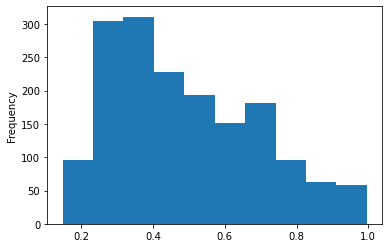

In [25]:
topic_of_interest = 0 # = "Topic 1" above.
doc_df[doc_df['Primary Topic'] == topic_of_interest]['Primary Perc'].plot(kind='hist')

We can then inspect the items which match the topic. Initially, we just look at the information in the items table. For "Topic 1" we can look at all with a proportion greater than `0.5`(but note that this is somewhat arbitrary - the main thing here is to ensure that you don't set the cut off so high that nothing appears).

In [32]:
cut_off = 0.5
matches = gensim_candidate_corpus.items[
    (doc_df['Primary Topic'] == topic_of_interest) &
    (doc_df['Primary Perc'] >= 0.5)
]
matches

,Title,Text,Newspaper,Date,Year,Tokenised,BOW
WC_18990503_ARTICLE27,TWO OF A TRADE.,[That two of a trade seldom agree is a common ...,WC,18990503,1899,"[two, trade, seldom, agree, common, weakness, ...","[(16, 1), (82, 1), (111, 1), (128, 1), (141, 1..."
LWM_18731015_ARTICLE35,SULPHURIC ACID FOR DIPHTHERIA SUCCESSFUL.,[Mr Greatbead's remedy for diphtheria is being...,LWM,18731015,1873,"[remedy, diphtheria, tried, success, two, rece...","[(8, 1), (19, 1), (91, 1), (107, 3), (176, 1),..."
WC_18850131_ARTICLE28,"MEN, WOMEN, AND THINGS.","["" A mad world my masters,"" — Old Play. The er...",WC,18850131,1885,"[mad, world, old, play, erase, less, celebrate...","[(16, 2), (17, 1), (34, 2), (77, 1), (88, 1), ..."
WC_18971202_ARTICLE31,UNTITLED,"["" Drunkenness is not a sin— simply an excess ...",WC,18971202,1897,"[drunkenness, sin, simply, excess, convivialit...","[(241, 1), (257, 1), (904, 1), (947, 1), (978,..."
WC_18990810_ARTICLE26,TUBERCULOUS PHEASANTS,"[(Pen Press- Association.), . ' y WELLINGTON, ...",WC,18990810,1899,"[pen, press, association, wellington, august, ...","[(29, 1), (34, 2), (228, 1), (373, 1), (445, 1..."
...,...,...,...,...,...,...,...
WC_18980209_ARTICLE25,UNTITLED,[Drunkennea? is not aain— •simply an Bxces9 of...,WC,18980209,1898,"[simply, conviviality, thirst, philosopher, no...","[(241, 1), (257, 1), (904, 1), (947, 1), (978,..."
ST_18880731_ARTICLE29,UNTITLED,[A Great Enter prise— The Dr Soule's American ...,ST,18880731,1888,"[great, enter, hop, bitters, company, one, bus...","[(16, 2), (87, 1), (209, 1), (223, 1), (227, 1..."
ST_18960109_ARTICLE9,"""PIE.""",[Granite ia quarried in Southern India by burn...,ST,18960109,1896,"[granite, quarried, southern, burning, woe, fi...","[(20, 1), (31, 1), (87, 1), (124, 1), (167, 1)..."
WC_18980413_ARTICLE42,QLD AND NEW WORLD WISDOM.,[Away in the dim mysterious years when the vas...,WC,18980413,1898,"[away, dim, mysterious, vast, yet, unbuilded, ...","[(29, 1), (32, 1), (34, 1), (73, 1), (87, 1), ..."


We can also look at the full text of the items. 

In [37]:
item_indices = matches.index
interact(
    html_text, 
    index=sorted(item_indices), 
    dataframe=fixed(candidate_corpus), 
    boldface=fixed(None)
)

interactive(children=(Dropdown(description='index', options=('AG_18980211_ARTICLE13', 'AG_18990515_ARTICLE27',…

<function __main__.html_text(index, dataframe, boldface=None)>

At this point it is a good idea to keep track of any items which you judge are appropriate or inappropriate for the corpus you are constructing. In this case, the majority seem to be not what we are after!

## Putting it All Together

The above presents a series of tools which can be used to understand the content of a candidate corpus both 'up close' by inspecting original articles and 'at a distance' by looking a statistical associations of terms. These tools are brought together in the process of corpus construction by enabling the user to get a sense of the _kind_ of material there might be in the corpus.

This enables the key decision point in the process: is this corpus sufficient for our purposes or is it not? If not, we will go around the cycle again.

If the answer is _no_ then we also gain inputs to the labelling stage. We have just seen, for instance, how topic modelling is useful for picking out material that we don't want. In the course of exploring a corpus, we will also have come across material that we know would would like to be in our corpus. Both sorts of information are useful for the labelling stage.

If we instead conclude that the corpus is sufficient, then the tools set out above can be used as part of an analysis of the corpus. It might be, for instance, that the cooccurrence networks for certain key terms or the topic models are sufficient for the purpose of the researcher.
